## Demonstrate the calculation of hard point matrix

this goes from load cell forces to [Fx, Fy, Fz, Mx, My, Mz],
 or from mirror position [x,y,z,rx,ry,rz] to hard point length

(yes, force * length = moments, rotation * length = length)

### Took engineering drawing data from slides emailed by Felipe on 4/9/2019

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

plt.jet();

<Figure size 432x288 with 0 Axes>

In [3]:
# input data
alpha = 40.550036 #deg
# for below, look at Felipe slide 6
# 1 and 2 point away from each other, so do 3 and 4, 5 and 6.
a1 = np.arctan(0.991276/3.724100)
a2 = np.arctan(1.003579/3.720803)
a3 = np.arctan(2.729527/2.720520)

beta = np.zeros(6)
beta[0] = a1 #angle between hard point *1* (vector) and +x axis
beta[1] = np.pi*1.5+ a2
beta[2] = np.pi - a3
beta[3] = a3
beta[4] = np.pi*1.5 - a2
beta[5] = np.pi - a1

alpha = alpha/180*np.pi

In [4]:
# check again Felipe's numbers
for i in range(6):
    print('beta[%d] = %7.3f degrees'%(i, beta[i]/np.pi*180))

beta[0] =  14.905 degrees
beta[1] = 285.095 degrees
beta[2] = 134.905 degrees
beta[3] =  45.095 degrees
beta[4] = 254.905 degrees
beta[5] = 165.095 degrees


In [5]:
dx = [-1.413072, -3.115501, -1.810974, 1.810974, 3.115501, 1.413072]
dy = [2.826964, -0.531179, -2.590149, -2.590149, -0.531179, 2.826964]

In [6]:
def calcMHP(alpha, beta, dx, dy, dz):
    '''
    inputs:
        alpha = inclination angle (angle between hard points and xy plane)
        beta[0:5] = when projected to xy plane, angle between hard points and +x axis
        dx[0:5], dy[0:5], dz[0:5] are the coordinates of the points of contact with back plate of the mirror.
    output:
        m = transformation matrix
        [Fx, Fy, Fz, Mx, My, Mz] = m * [l1, l2, l3, l4, l5, l6]
        l1:6 is are hard point load cell readings.
        or
        [d1,d2,d3,d4,d5,d6] = m * [x,y,z,rx,ry,rz]
        d1:6 is are hard point displacements (length change)
        
        (yes, force * length = moments, rotation * length = length)
        When deriving [Fx, Fy, Fz, Mx, My, Mz] from [l1, l2, l3, l4, l5, l6], 
            calculate how each HP force contribute to total force and moments.
        When deriving [d1,d2,d3,d4,d5,d6] from [x,y,z,rx,ry,rz],
            calculate how each system motion extends or squeeze each HP.
            To help visualize, think about the following - 
            if you hang a rod from the ceiling, and it is 30 deg from vertical, 
            and pull it further away from vertical, this motion is decomposed into 
            a lengthening motion and a rotation around the pivot.
    '''
    m = np.zeros((6,6))
    for i in range(6):
        m[0,i] = np.cos(alpha)*np.cos(beta[i])
        m[1,i] = np.cos(alpha)*np.sin(beta[i])
        m[2,i] = np.sin(alpha)
        m[3,i] = np.sin(alpha)*dy[i] - np.cos(alpha)*np.sin(beta[i])*dz[i]
        m[4,i] = np.cos(alpha)*np.cos(beta[i])*dz[i] - np.sin(alpha)*dx[i]
        m[5,i] = np.cos(alpha)*np.sin(beta[i])*dx[i] - np.cos(alpha)*np.cos(beta[i])*dy[i]
    return m

### if the momments are centered on actuator plane (This is the right thing to do)

see https://github.com/lsst-ts/ts_m1m3support/pull/67

In [7]:
dz = np.ones(6)*0
m0 = calcMHP(alpha, beta, dx, dy, dz)
print(' columns: l1 l2 l3 l4 l5 l6\n or   x,y,z,rx,ry,rz = MirrorPositionToHardpointDisplacementTable.csv')
print(m0)
print(' columns: Fx, Fy, Fz, Mx, My, Mz\n or d1,d2,d3,d4,d5,d6')
print(np.linalg.pinv(m0))

 columns: l1 l2 l3 l4 l5 l6
 or   x,y,z,rx,ry,rz = MirrorPositionToHardpointDisplacementTable.csv
[[ 0.73427166  0.19787323 -0.53639829  0.53639829 -0.19787323 -0.73427166]
 [ 0.19544746 -0.73362167  0.53817418  0.53817418 -0.73362167  0.19544746]
 [ 0.65011186  0.65011186  0.65011186  0.65011186  0.65011186  0.65011186]
 [ 1.83784282 -0.34532577 -1.68388658 -1.68388658 -0.34532577  1.83784282]
 [ 0.91865486  2.02542414  1.17733567 -1.17733567 -2.02542414 -0.91865486]
 [-2.35194086  2.39070516 -2.36397094  2.36397094 -2.39070516  2.35194086]]
 columns: Fx, Fy, Fz, Mx, My, Mz
 or d1,d2,d3,d4,d5,d6
[[ 0.40294457  0.16648103  0.27188671  0.15817726  0.04317411 -0.06992825]
 [ 0.03165966 -0.43800858  0.25218361 -0.042626    0.15886127  0.07193441]
 [-0.36887631  0.27152756  0.2450281  -0.11555125  0.11770343 -0.06918822]
 [ 0.36887631  0.27152756  0.2450281  -0.11555125 -0.11770343  0.06918822]
 [-0.03165966 -0.43800858  0.25218361 -0.042626   -0.15886127 -0.07193441]
 [-0.40294457  0.1664

### Check the calculated matrix against what was in the software (accroding to Chris Contaxis)

### We used to have the moments centered on CG (which was wrong thing to do)

see https://github.com/lsst-ts/ts_m1m3support/pull/67

In [8]:
dz = np.ones(6)*(-0.3930344)
m1 = calcMHP(alpha, beta, dx, dy, dz)
print(m1)
print(np.linalg.pinv(m1))
#this goes from load cell forces to [Fx, Fy, Fz, Mx, My, Mz],
#. or from mirror position [x,y,z,rx,ry,rz] to hard point length
# It matches https://github.com/lsst-ts/ts_m1m3support/blob/master/SettingFiles/Tables/MirrorPositionToHardpointDisplacementTable.csv

[[ 0.73427166  0.19787323 -0.53639829  0.53639829 -0.19787323 -0.73427166]
 [ 0.19544746 -0.73362167  0.53817418  0.53817418 -0.73362167  0.19544746]
 [ 0.65011186  0.65011186  0.65011186  0.65011186  0.65011186  0.65011186]
 [ 1.91466039 -0.63366432 -1.47236561 -1.47236561 -0.63366432  1.91466039]
 [ 0.63006084  1.94765316  1.38815865 -1.38815865 -1.94765316 -0.63006084]
 [-2.35194086  2.39070516 -2.36397094  2.36397094 -2.39070516  2.35194086]]
[[ 0.41991348  0.10431192  0.27188671  0.15817726  0.04317411 -0.06992825]
 [ 0.09409761 -0.4212551   0.25218361 -0.042626    0.15886127  0.07193441]
 [-0.32261481  0.31694317  0.2450281  -0.11555125  0.11770343 -0.06918822]
 [ 0.32261481  0.31694317  0.2450281  -0.11555125 -0.11770343  0.06918822]
 [-0.09409761 -0.4212551   0.25218361 -0.042626   -0.15886127 -0.07193441]
 [-0.41991348  0.10431192  0.27188671  0.15817726 -0.04317411  0.06992825]]


In [9]:
# this is what we use *now* (2019 for Mirror Lab testing)
mn = np.loadtxt('data/MHP.txt')*-1
print(mn)

[[ 0.7416  0.2036 -0.538   0.538  -0.2036 -0.7415]
 [ 0.1931 -0.7387  0.5457  0.5457 -0.7387  0.193 ]
 [ 0.6425  0.6425  0.6425  0.6425  0.6425  0.6425]
 [ 1.8493 -0.3791 -1.4706 -1.4707 -0.3792  1.8493]
 [ 0.6294  1.9161  1.2859 -1.2873 -1.9175 -0.631 ]
 [-2.3235  2.323  -2.3234  2.3245 -2.3248  2.3238]]


#### Neither m0 nor mn (my calculations centered on backplate or CG) matched Chris' matrix well

### But m0 matches Felipe slides 12 (5/30/19) perfectly. So, m0 is the right matrix to use.

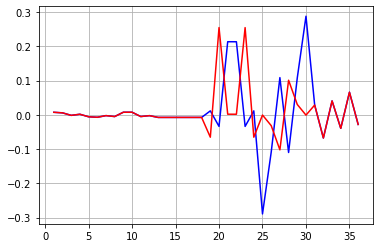

In [10]:
x0 = np.arange(36)+1
plt.plot(x0, mn.reshape(-1,1)-m0.reshape(-1,1), 'b')
plt.plot(x0, mn.reshape(-1,1)-m1.reshape(-1,1), 'r')
plt.grid()

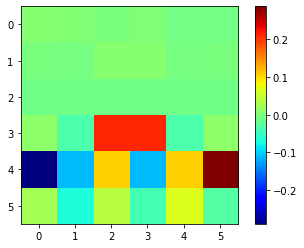

In [11]:
plt.imshow(mn-m0)
plt.colorbar()

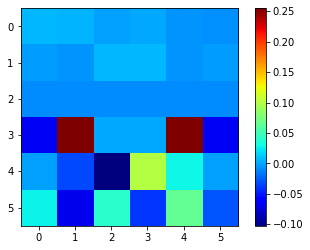

In [12]:
plt.imshow(mn-m1)
plt.colorbar()

### Check and clarify the csv tables in the software (March 2021)

In [13]:
csvFile = '%s/lsst_stack/ts_m1m3support/SettingFiles/Tables/MirrorPositionToHardpointDisplacementTable.csv'%os.environ['HOME']
aa = pd.read_csv(csvFile)
m1 = np.array(aa)[:,1:].astype(float)
csvFile = '%s/lsst_stack/ts_m1m3support/SettingFiles/Tables/HardpointDisplacementToMirrorPositionTable.csv'%os.environ['HOME']
bb = pd.read_csv(csvFile)
m2 = np.array(bb)[:,1:].astype(float)
csvFile = '%s/lsst_stack/ts_m1m3support/SettingFiles/Tables/HardpointForceMomentTable.csv'%os.environ['HOME']
cc = pd.read_csv(csvFile)
m3 = np.array(cc)[:,1:]

In [14]:
ii = np.matmul(m1,m2)
np.set_printoptions(precision=4, suppress=True)
print(ii)

[[ 1.  0.  0.  0. -0.  0.]
 [-0.  1. -0.  0. -0.  0.]
 [-0.  0.  1.  0. -0. -0.]
 [ 0. -0. -0.  1. -0.  0.]
 [-0.  0.  0. -0.  1.  0.]
 [ 0. -0.  0. -0.  0.  1.]]


In [15]:
aa

,HP,X,Y,Z,Rx,Ry,Rz
0,3,-0.536402,0.538178,0.650116,-0.028894,0.019833,-0.040259
1,4,0.536404,0.538176,0.650114,-0.028894,-0.019833,0.040259
2,5,-0.197874,-0.733627,0.650112,-0.002729,-0.034939,-0.040258
3,6,-0.734276,0.195449,0.650112,0.031623,-0.015106,0.040258
4,1,0.734276,0.195447,0.650105,0.031623,0.015106,-0.040259
5,2,0.197873,-0.733627,0.650112,-0.002729,0.034940,0.040259


In [16]:
bb

,direction,HP1,HP2,HP3,HP4,HP5,HP6
0,x,-0.367990,0.367991,-0.034760,-0.402749,0.402753,0.034760
1,Y,0.252596,0.252595,-0.444990,0.192394,0.192394,-0.444989
2,Z,0.256366,0.256365,0.256365,0.256368,0.256368,0.256365
3,Rx,-6.831599,-6.831564,-2.520108,9.351774,9.351760,-2.520099
4,Ry,6.854204,-6.854183,-9.343445,-2.489255,2.489222,9.343463
5,Rz,-4.139905,4.139904,-4.139912,4.139896,-4.139920,4.139905


### Yes the below is the table that is still there as of 4/16/21. But Felipe confirmed that it is wrong (slide 13, dated 5/30/19). So we are getting it updated today with m0 above.

In [17]:
cc

,ID,Fx,Fy,Fz,Mx,My,Mz
0,1,-0.7416,-0.2036,0.5380,-0.5380,0.2036,0.7415
1,2,-0.1931,0.7387,-0.5457,-0.5457,0.7387,-0.1930
2,3,-0.6425,-0.6425,-0.6425,-0.6425,-0.6425,-0.6425
3,4,-1.8493,0.3791,1.4706,1.4707,0.3792,-1.8493
4,5,-0.6294,-1.9161,-1.2859,1.2873,1.9175,0.6310
5,6,2.3235,-2.3230,2.3234,-2.3245,2.3248,-2.3238
